# AlexNet

In [6]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

from data_loading_functions import split_train_test_loaders, show_img, convert_lab

# Load Data and Preprocessing 

In [7]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, 256)

# Display Images

In [9]:
def show_img2(data):
    loader = DataLoader(data, 4, shuffle=True)

    batch = next(iter(loader))
    img, lab = batch

    labels = convert_lab(lab)
    fig, axes = plt.subplots(1, 4, figsize = (10,10))
    
    for ind, image in enumerate(img):
        print(image.shape)
        ax[i].imshow(image)
    # for i in range(4):
    #     plt.imshow()

    # grid = torchvision.utils.make_grid(img, nrow=4)
    # grid = make_grid(x, normalize=normalize, nrow=4)
    # npgrid = grid.cpu().numpy()

    # plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

    # ax = plt.gca()
    # ax.xaxis.set_visible(False)
    # ax.yaxis.set_visible(False)

    # if not (title == ''):
    #     plt.title(title)
    # plt.figure(figsize=(11, 11))
    # plt.imshow(np.transpose(grid, (1, 2, 0)))

    print(f'actual labels: {convert_lab(lab)}')
    print(f'numerical labels: {lab}')

show_img2(datas[0])

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
actual labels: ['Normal', 'Normal', 'Lung_Opacity', 'Normal']
numerical labels: tensor([2, 2, 1, 2])


In [8]:
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 224, 224])
Image label dimensions: torch.Size([256])
tensor([1, 2, 2, 2, 2, 1, 2, 2, 2, 1])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 224, 224])
Image label dimensions: torch.Size([256])
tensor([0, 2, 0, 3, 1, 2, 2, 2, 1, 1])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 224, 224])
Image label dimensions: torch.Size([256])
tensor([1, 1, 0, 0, 2, 1, 0, 2, 3, 1])


In [1]:
print(f'Length of Training: {len(datas[0])}')
print(f'Length of Validation: {len(datas[1])}')
print(f'Length of Testing: {len(datas[2])}')

NameError: name 'train_data' is not defined

# AlexNet

## Settings

In [2]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

In [3]:
model_ft = torchvision.models.alexnet(pretrained=True)
model_ft

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Pretrained AlexNet fine tune fc layer + last conv layer

In [8]:
model_ft = torchvision.models.alexnet(pretrained=True)

for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

#train last layer
for param in model_ft.features[-1:].parameters():
    param.requires_grad = True

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/040 | Batch 0000/0133 | Loss: 1.9859
Epoch: 001/040 | Batch 0050/0133 | Loss: 0.4226
Epoch: 001/040 | Batch 0100/0133 | Loss: 0.3943
Epoch: 001/040 | Train: 84.63% | Validation: 83.28%
Time elapsed: 2.65 min
Epoch: 002/040 | Batch 0000/0133 | Loss: 0.4175
Epoch: 002/040 | Batch 0050/0133 | Loss: 0.4517
Epoch: 002/040 | Batch 0100/0133 | Loss: 0.3682
Epoch: 002/040 | Train: 89.07% | Validation: 87.81%
Time elapsed: 5.28 min
Epoch: 003/040 | Batch 0000/0133 | Loss: 0.3919
Epoch: 003/040 | Batch 0050/0133 | Loss: 0.3287
Epoch: 003/040 | Batch 0100/0133 | Loss: 0.3577
Epoch: 003/040 | Train: 90.49% | Validation: 88.76%
Time elapsed: 7.93 min
Epoch: 004/040 | Batch 0000/0133 | Loss: 0.3253
Epoch: 004/040 | Batch 0050/0133 | Loss: 0.3794
Epoch: 004/040 | Batch 0100/0133 | Loss: 0.3445
Epoch: 004/040 | Train: 90.00% | Validation: 89.23%
Time elapsed: 10.58 min
Epoch: 005/040 | Batch 0000/0133 | Loss: 0.3020
Epoch: 005/040 | Batch 0050/0133 | Loss: 0.3223
Epoch: 005/040 | Batch 0100

# Evaluation AlexNet: fine tuned fc

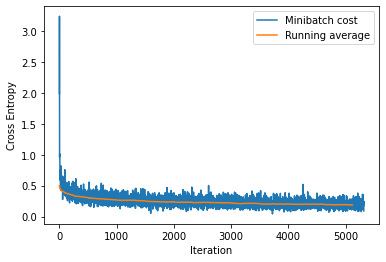

In [9]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

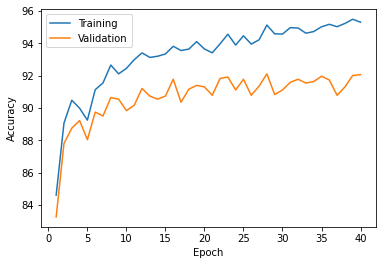

In [10]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

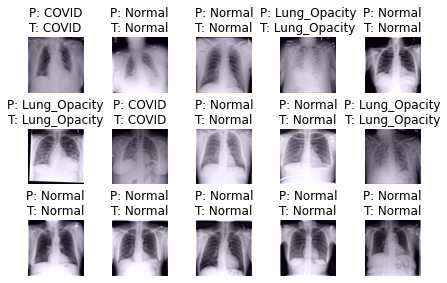

In [12]:
model_ft.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

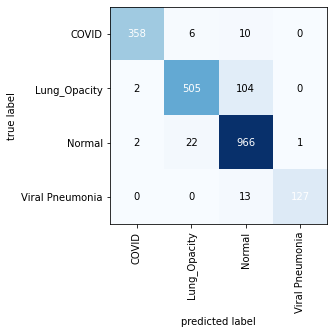

In [13]:
mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# Framework only no Pretrained Alexnet

In [12]:
model_scratch = torchvision.models.alexnet(pretrained=False)

model_scratch.classifier[4] = nn.Linear(in_features=4096, out_features=2048, bias=True)
model_scratch.classifier[6] = nn.Linear(in_features=2048, out_features=4, bias=True)

torch.manual_seed(RANDOM_SEED)
model_scratch.to(DEVICE)

optimizer = torch.optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_scratch, train_acc_list_scratch, valid_acc_list_scratch = train_model(num_epochs = 50, model = model_scratch, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/050 | Batch 0000/0067 | Loss: 1.3949
Epoch: 001/050 | Batch 0050/0067 | Loss: 0.8976
Epoch: 001/050 | Train: 68.98% | Validation: 69.39%
Time elapsed: 2.50 min
Epoch: 002/050 | Batch 0000/0067 | Loss: 0.8469
Epoch: 002/050 | Batch 0050/0067 | Loss: 0.7342
Epoch: 002/050 | Train: 76.12% | Validation: 75.77%
Time elapsed: 4.79 min
Epoch: 003/050 | Batch 0000/0067 | Loss: 0.5531
Epoch: 003/050 | Batch 0050/0067 | Loss: 0.5348
Epoch: 003/050 | Train: 77.95% | Validation: 77.33%
Time elapsed: 7.11 min
Epoch: 004/050 | Batch 0000/0067 | Loss: 0.6144
Epoch: 004/050 | Batch 0050/0067 | Loss: 0.4842
Epoch: 004/050 | Train: 81.55% | Validation: 80.59%
Time elapsed: 9.47 min
Epoch: 005/050 | Batch 0000/0067 | Loss: 0.6009
Epoch: 005/050 | Batch 0050/0067 | Loss: 0.5590
Epoch: 005/050 | Train: 82.85% | Validation: 81.48%
Time elapsed: 11.70 min
Epoch: 006/050 | Batch 0000/0067 | Loss: 0.4443
Epoch: 006/050 | Batch 0050/0067 | Loss: 0.5052
Epoch: 006/050 | Train: 84.59% | Validation: 82.


# Evaluation

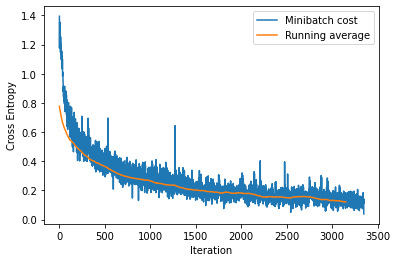

In [13]:
plt.plot(minibatch_loss_list_scratch, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_scratch, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

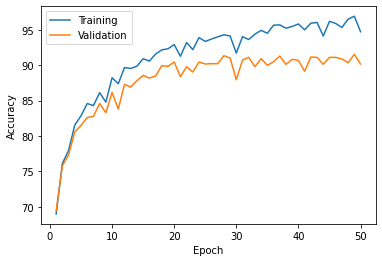

In [16]:
plt.plot(np.arange(1, 50+1), train_acc_list_scratch, label='Training')
plt.plot(np.arange(1, 50+1), valid_acc_list_scratch, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

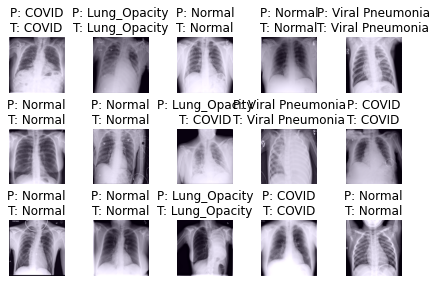

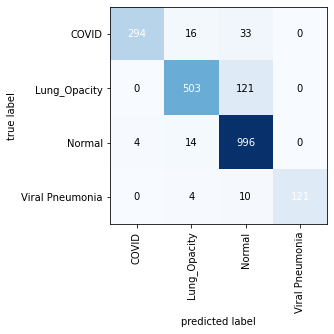

In [17]:
model_scratch.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_scratch, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_scratch, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# AlexNet: 

## Epoch 40 
## Batch size: 64

In [2]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, 64)

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 40

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

model_ft = torchvision.models.alexnet(pretrained=True)

for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

#train last layer
for param in model_ft.features[-1:].parameters():
    param.requires_grad = True

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/040 | Batch 0000/0265 | Loss: 1.7630
Epoch: 001/040 | Batch 0050/0265 | Loss: 0.6181
Epoch: 001/040 | Batch 0100/0265 | Loss: 0.5074
Epoch: 001/040 | Batch 0150/0265 | Loss: 0.2667
Epoch: 001/040 | Batch 0200/0265 | Loss: 0.3559
Epoch: 001/040 | Batch 0250/0265 | Loss: 0.4700
Epoch: 001/040 | Train: 88.15% | Validation: 86.92%
Time elapsed: 2.20 min
Epoch: 002/040 | Batch 0000/0265 | Loss: 0.5640
Epoch: 002/040 | Batch 0050/0265 | Loss: 0.4509
Epoch: 002/040 | Batch 0100/0265 | Loss: 0.3013
Epoch: 002/040 | Batch 0150/0265 | Loss: 0.5319
Epoch: 002/040 | Batch 0200/0265 | Loss: 0.3235
Epoch: 002/040 | Batch 0250/0265 | Loss: 0.3597
Epoch: 002/040 | Train: 89.16% | Validation: 87.72%
Time elapsed: 4.32 min
Epoch: 003/040 | Batch 0000/0265 | Loss: 0.2295
Epoch: 003/040 | Batch 0050/0265 | Loss: 0.2407
Epoch: 003/040 | Batch 0100/0265 | Loss: 0.3489
Epoch: 003/040 | Batch 0150/0265 | Loss: 0.4087
Epoch: 003/040 | Batch 0200/0265 | Loss: 0.3222
Epoch: 003/040 | Batch 0250/0265 |

### Evaluation

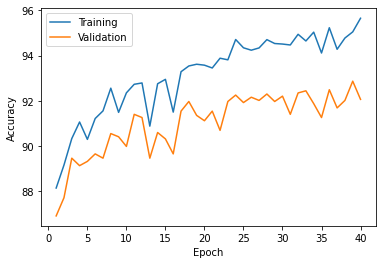

In [4]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

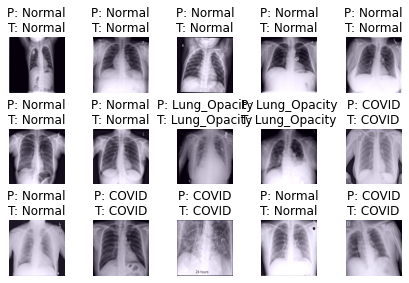

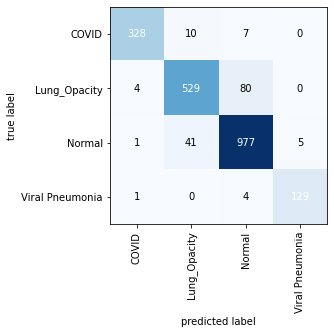

In [5]:
model_ft.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# AlexNet: 
## Epoch 40 
## Batch size: 128

In [6]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, 128)

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
NUM_EPOCHS = 40

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

model_ft = torchvision.models.alexnet(pretrained=True)

for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

#train last layer
for param in model_ft.features[-1:].parameters():
    param.requires_grad = True

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/040 | Batch 0000/0133 | Loss: 1.6060
Epoch: 001/040 | Batch 0050/0133 | Loss: 0.5486
Epoch: 001/040 | Batch 0100/0133 | Loss: 0.5156
Epoch: 001/040 | Train: 83.58% | Validation: 82.10%
Time elapsed: 2.11 min
Epoch: 002/040 | Batch 0000/0133 | Loss: 0.5718
Epoch: 002/040 | Batch 0050/0133 | Loss: 0.3874
Epoch: 002/040 | Batch 0100/0133 | Loss: 0.3289
Epoch: 002/040 | Train: 87.43% | Validation: 85.07%
Time elapsed: 4.08 min
Epoch: 003/040 | Batch 0000/0133 | Loss: 0.4119
Epoch: 003/040 | Batch 0050/0133 | Loss: 0.3972
Epoch: 003/040 | Batch 0100/0133 | Loss: 0.3497
Epoch: 003/040 | Train: 90.49% | Validation: 88.47%
Time elapsed: 6.05 min
Epoch: 004/040 | Batch 0000/0133 | Loss: 0.2836
Epoch: 004/040 | Batch 0050/0133 | Loss: 0.3306
Epoch: 004/040 | Batch 0100/0133 | Loss: 0.2804
Epoch: 004/040 | Train: 91.62% | Validation: 90.17%
Time elapsed: 8.01 min
Epoch: 005/040 | Batch 0000/0133 | Loss: 0.2783
Epoch: 005/040 | Batch 0050/0133 | Loss: 0.3435
Epoch: 005/040 | Batch 0100/

### Evaluation

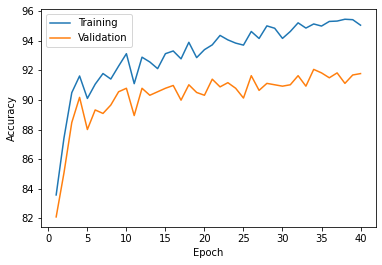

In [7]:
plt.plot(np.arange(1,NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

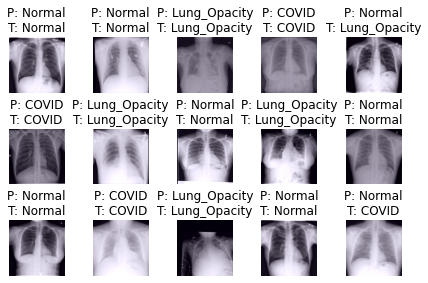

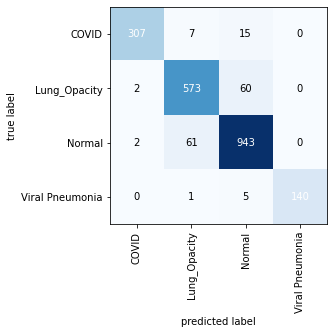

In [8]:
model_ft.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# AlexNet: 

### Epoch 20 
### Batch size: 64

In [9]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, 64)

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

model_ft = torchvision.models.alexnet(pretrained=True)

for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

#train last layer
for param in model_ft.features[-1:].parameters():
    param.requires_grad = True

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/020 | Batch 0000/0265 | Loss: 1.4905
Epoch: 001/020 | Batch 0050/0265 | Loss: 0.6324
Epoch: 001/020 | Batch 0100/0265 | Loss: 0.6032
Epoch: 001/020 | Batch 0150/0265 | Loss: 0.4466
Epoch: 001/020 | Batch 0200/0265 | Loss: 0.3534
Epoch: 001/020 | Batch 0250/0265 | Loss: 0.3198
Epoch: 001/020 | Train: 86.86% | Validation: 87.48%
Time elapsed: 1.99 min
Epoch: 002/020 | Batch 0000/0265 | Loss: 0.4339
Epoch: 002/020 | Batch 0050/0265 | Loss: 0.3159
Epoch: 002/020 | Batch 0100/0265 | Loss: 0.2282
Epoch: 002/020 | Batch 0150/0265 | Loss: 0.3597
Epoch: 002/020 | Batch 0200/0265 | Loss: 0.2248
Epoch: 002/020 | Batch 0250/0265 | Loss: 0.3715
Epoch: 002/020 | Train: 86.46% | Validation: 86.40%
Time elapsed: 3.99 min
Epoch: 003/020 | Batch 0000/0265 | Loss: 0.4094
Epoch: 003/020 | Batch 0050/0265 | Loss: 0.4636
Epoch: 003/020 | Batch 0100/0265 | Loss: 0.3150
Epoch: 003/020 | Batch 0150/0265 | Loss: 0.2727
Epoch: 003/020 | Batch 0200/0265 | Loss: 0.3991
Epoch: 003/020 | Batch 0250/0265 |

### Evaluation

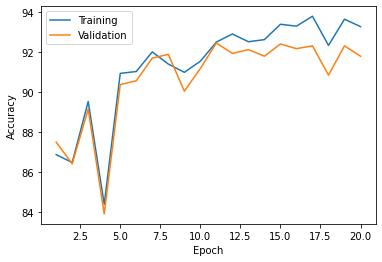

In [10]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

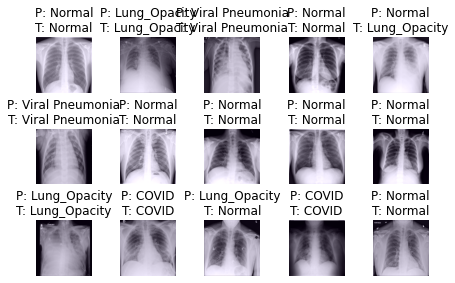

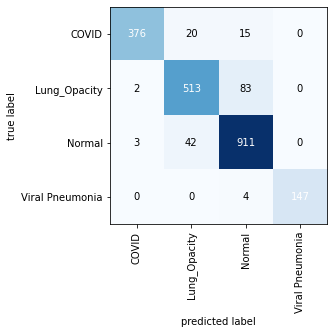

In [11]:
model_ft.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# AlexNet: 

## Epoch 20 
## Batch size: 128

In [12]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, 128)

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 128
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

model_ft = torchvision.models.alexnet(pretrained=True)

for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

#train last layer
for param in model_ft.features[-1:].parameters():
    param.requires_grad = True

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/020 | Batch 0000/0133 | Loss: 1.5486
Epoch: 001/020 | Batch 0050/0133 | Loss: 0.3948
Epoch: 001/020 | Batch 0100/0133 | Loss: 0.4569
Epoch: 001/020 | Train: 85.42% | Validation: 84.70%
Time elapsed: 2.20 min
Epoch: 002/020 | Batch 0000/0133 | Loss: 0.5384
Epoch: 002/020 | Batch 0050/0133 | Loss: 0.3380
Epoch: 002/020 | Batch 0100/0133 | Loss: 0.3176
Epoch: 002/020 | Train: 89.35% | Validation: 88.95%
Time elapsed: 4.24 min
Epoch: 003/020 | Batch 0000/0133 | Loss: 0.3885
Epoch: 003/020 | Batch 0050/0133 | Loss: 0.3248
Epoch: 003/020 | Batch 0100/0133 | Loss: 0.4093
Epoch: 003/020 | Train: 90.36% | Validation: 90.08%
Time elapsed: 6.34 min
Epoch: 004/020 | Batch 0000/0133 | Loss: 0.3029
Epoch: 004/020 | Batch 0050/0133 | Loss: 0.2853
Epoch: 004/020 | Batch 0100/0133 | Loss: 0.3569
Epoch: 004/020 | Train: 90.26% | Validation: 90.17%
Time elapsed: 8.36 min
Epoch: 005/020 | Batch 0000/0133 | Loss: 0.5411
Epoch: 005/020 | Batch 0050/0133 | Loss: 0.4931
Epoch: 005/020 | Batch 0100/

### Evaluation

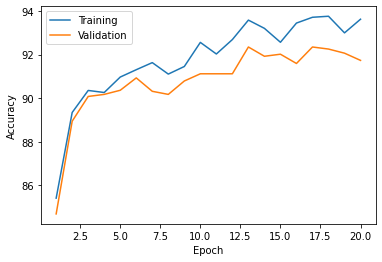

In [13]:
plt.plot(np.arange(1,NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

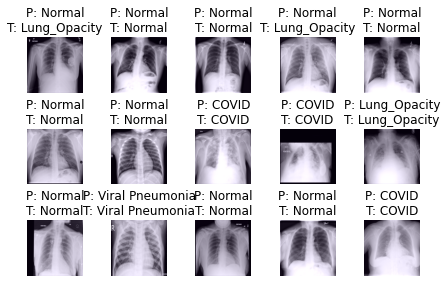

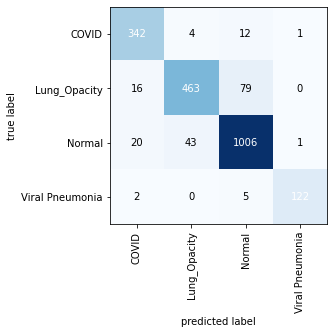

In [14]:
model_ft.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# AlexNet: 

## Epoch 20 
## Batch size: 256

In [15]:
dataset_path = '.\\COVID-19_Radiography_Dataset'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path, 256)

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

model_ft = torchvision.models.alexnet(pretrained=True)

for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

#train last layer
for param in model_ft.features[-1:].parameters():
    param.requires_grad = True

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)


torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  

minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/020 | Batch 0000/0067 | Loss: 1.5662
Epoch: 001/020 | Batch 0050/0067 | Loss: 0.3989
Epoch: 001/020 | Train: 86.37% | Validation: 85.45%
Time elapsed: 2.03 min
Epoch: 002/020 | Batch 0000/0067 | Loss: 0.3696
Epoch: 002/020 | Batch 0050/0067 | Loss: 0.3316
Epoch: 002/020 | Train: 88.38% | Validation: 87.25%
Time elapsed: 4.05 min
Epoch: 003/020 | Batch 0000/0067 | Loss: 0.3749
Epoch: 003/020 | Batch 0050/0067 | Loss: 0.3650
Epoch: 003/020 | Train: 90.91% | Validation: 88.80%
Time elapsed: 6.08 min
Epoch: 004/020 | Batch 0000/0067 | Loss: 0.2903
Epoch: 004/020 | Batch 0050/0067 | Loss: 0.3068
Epoch: 004/020 | Train: 89.42% | Validation: 87.72%
Time elapsed: 8.12 min
Epoch: 005/020 | Batch 0000/0067 | Loss: 0.4091
Epoch: 005/020 | Batch 0050/0067 | Loss: 0.2819
Epoch: 005/020 | Train: 90.71% | Validation: 88.29%
Time elapsed: 10.15 min
Epoch: 006/020 | Batch 0000/0067 | Loss: 0.2350
Epoch: 006/020 | Batch 0050/0067 | Loss: 0.3353
Epoch: 006/020 | Train: 89.97% | Validation: 87.

### Evaluation

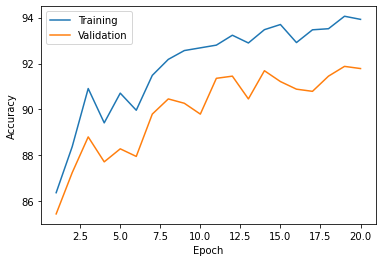

In [16]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

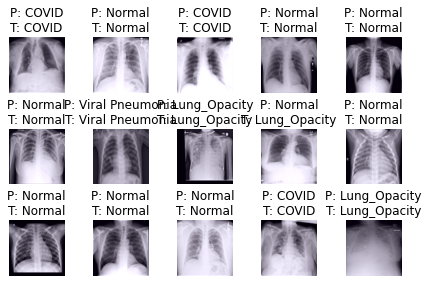

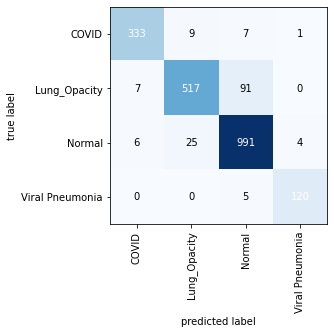

In [17]:
model_ft.cpu()
unnormalizer = UnNormalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2255))
class_dict  = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

show_examples(model=model_ft, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_ft, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()